# project-template

In [1]:
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from isas import Interface
from isas.preprocess.sensor_modeling import create_sensor, create_sensor_structural_model_connection
from isas.preprocess.structural_modeling import create_finite_element_model
from isas_base.data import StaticData
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

## 1. Set up

Constant.

In [3]:
DATADRIVE = '/root/datadrive_tmp'
SENSOR_NAME = 'test_sensor'
STRUCTURAL_MODEL_NAME = 'test_model'

Copy directory

In [4]:
if Path(DATADRIVE).exists():
    shutil.rmtree(DATADRIVE)
shutil.copytree('/root/datadrive', DATADRIVE)

'/root/datadrive_tmp'

Check directory

In [5]:
data_dir = Path(f'{DATADRIVE}/static_data')
assert data_dir.exists()
time_series_dir = Path(f'{DATADRIVE}/dynamic_data')
assert time_series_dir.exists()

In [6]:
!tree $DATADRIVE

/root/datadrive_tmp
├── dynamic_data
│   └── init_tsdb
│       └── ground_truth_rosette_strain_x.csv
└── static_data
    └── init_rdb
        └── 010_time_series_metadata.csv

5 directories, 2 files


## 2. Create structural models and sensors

### 2.1 create structural models

In [7]:
cfg = {
    'GEOMETRY_TYPE': 'PLATE',
    'WIDTH': 80,
    'HEIGHT': 10,
    'THICKNESS': 1,
    'WIDTH_DIVIDE_NUM': 8,
    'HEIGHT_DIVIDE_NUM': 1,
    'YOUNGS_MODULUS': 70e+3,
    'POISSONS_RATIO': 0.3,
    'R3': 0,
    'ELEM_TYPE': 'iQS4',
    'NODE_NUM': 4,
    'CONSTRAINT': {  # constraint_dof: {node_id: constraint_value}
        123456: {1: 0, 12: 0},
    },
}
structural_model = create_finite_element_model(cfg)

In [8]:
structural_model

FiniteElementModel(fe_node=               x     y    z
fe_node_id                 
1            0.0   0.0  0.0
2           10.0   0.0  0.0
3           20.0   0.0  0.0
4           30.0   0.0  0.0
5           40.0   0.0  0.0
6           50.0   0.0  0.0
7           60.0   0.0  0.0
8           70.0   0.0  0.0
9           80.0   0.0  0.0
10           0.0  10.0  0.0
11          10.0  10.0  0.0
12          20.0  10.0  0.0
13          30.0  10.0  0.0
14          40.0  10.0  0.0
15          50.0  10.0  0.0
16          60.0  10.0  0.0
17          70.0  10.0  0.0
18          80.0  10.0  0.0, fe_elem=           elem_type  node_num   r3  youngs_modulus  poissons_ratio
fe_elem_id                                                         
1               iQS4         4  0.0         70000.0             0.3
2               iQS4         4  0.0         70000.0             0.3
3               iQS4         4  0.0         70000.0             0.3
4               iQS4         4  0.0         70000.0             

## 2.2 create sensors

In [9]:
cfg = {
    'SETTING_TYPE': 'discrete',  # 'discrete', 'continuous'
    'LOCATIONAL': True,
    'DIRECTIONAL': False,
    'LOCATION': [
        [5, 5, 0], 
        [25, 5, 0],
        [45, 5, 0],
        [65, 5, 0],
    ],
}
sensor = create_sensor(cfg)

In [10]:
cfg = {
    'R1': 0,
    'R2': 0,
    'R3': -1,
    'COMPONENT_NAME': 'fe_elem',
}
sensor = create_sensor_structural_model_connection(cfg, sensor, STRUCTURAL_MODEL_NAME, structural_model)

In [11]:
sensor

Sensor(locational=True, directional=False, structural_model_info={'test_model': StructuralModelInfo(id=None, component_name='fe_elem', connection=           fe_elem_id   r1   r2   r3
sensor_id                           
1                   1  0.0  0.0 -1.0
2                   3  0.0  0.0 -1.0
3                   5  0.0  0.0 -1.0
4                   7  0.0  0.0 -1.0)}, data=            x  y  z
sensor_id          
1           5  5  0
2          25  5  0
3          45  5  0
4          65  5  0, METADATA_KEYS=('locational', 'directional'))

## 2.3 visualize

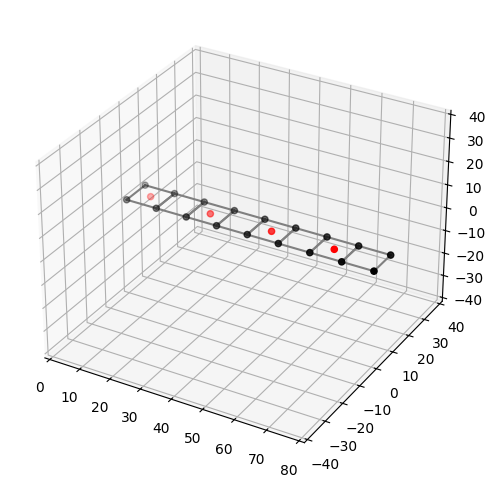

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
node_df = structural_model.fe_node
ax.scatter(node_df.x, node_df.y, node_df.z, c='black')
for _, group_df in structural_model.fe_connection.groupby('fe_elem_id'):
    node_ids = group_df['fe_node_id'].to_numpy().tolist()
    for i, j in ((0, 1), (1, 2), (2, 3), (3, 0)):
        node_df = structural_model.fe_node.loc[[node_ids[i], node_ids[j]], :]
        ax.plot(node_df.x, node_df.y, node_df.z, c='gray')
sensor_df = sensor.data
ax.scatter(sensor_df.x, sensor_df.y, sensor_df.z, c='red')
ax.set_xlim(0, 80)
ax.set_ylim(-40, 40)
ax.set_zlim(-40, 40)
plt.show()

## 3. analysis

### 3.1 Construct isas Interface

In [13]:
cfg_path = '../cfg/service.yml'

In [14]:
interface = Interface(
    cfg_path,
    StaticData(
        sensors={SENSOR_NAME: sensor},
        structural_models={STRUCTURAL_MODEL_NAME: structural_model},
        ),
    )

In [15]:
interface.models

{'measurement': [<isas_subpackage_template.measurement.model.Model at 0xffff94e97090>],
 'analysis': [<isas_subpackage_template.analysis.model.Model at 0xffff4f3d6b10>]}

### 3.2 run isas

In [16]:
dynamic_data = interface()

In [17]:
dynamic_data

DynamicData(time_series_data={'ground_truth_rosette_strain_x': TimeSeriesData(fields=                            1         2         3         4         5  \
time                                                                    
2020-04-25 00:00:00  0.000025  0.000076  0.000126  0.000075  0.000025   
2020-04-25 00:00:01  0.000025  0.000074  0.000124  0.000074  0.000024   
2020-04-25 00:00:02  0.000024  0.000071  0.000118  0.000070  0.000023   
2020-04-25 00:00:03  0.000023  0.000067  0.000112  0.000067  0.000022   
2020-04-25 00:00:04  0.000022  0.000064  0.000107  0.000064  0.000021   
2020-04-25 00:00:05  0.000021  0.000063  0.000104  0.000062  0.000021   
2020-04-25 00:00:06  0.000021  0.000062  0.000103  0.000061  0.000020   
2020-04-25 00:00:07  0.000021  0.000063  0.000104  0.000062  0.000020   
2020-04-25 00:00:08  0.000022  0.000064  0.000107  0.000064  0.000021   
2020-04-25 00:00:09  0.000023  0.000067  0.000112  0.000067  0.000022   
2020-04-25 00:00:10  0.000024  0.000071

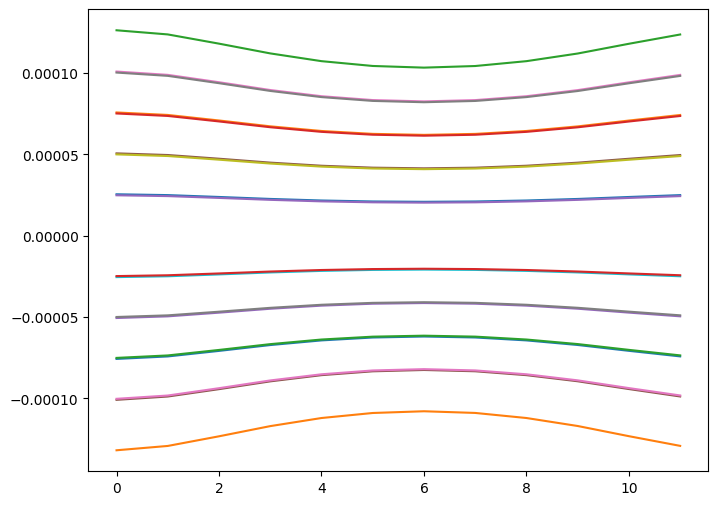

In [18]:
res = dynamic_data.time_series_data['analyzed_rosette_strain_x'].fields
plt.figure(figsize=(8, 6))
x = np.arange(len(res))
plt.plot(x, res.values)
plt.show()